In [88]:
%pip install pandas seaborn matplotlib imblearn xgboost scikit-learn mlxtend

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\PC\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Loan Default Prediction

- *Default = The person didn’t pay their loan (missed payments, skipped entirely)*

- *No Default = The person paid their loan on time*

**Goal**: The model should be able to predict whether a new person will default, based on their income, loan, credit score, etc.

Following these steps:
1. **Understand the Problem** – What are you trying to predict?
2. **Explore the Data** – What information do you have?
3. **Clean the Data** – Fix errors, remove duplicates, handle missing values.
4. **Prepare the Data** – Convert it into numbers that the model can understand.
5. **Model the Data** – Try multiple models to see which works best.
6. **Evaluate the Model** – How well is the model doing?
7. **Improve** – Tune, balance, and try again.

### 1. Analyze and Data Cleaning

*Loan and inspect the dataset*

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc
import numpy as np
from scipy.stats import chi2_contingency

In [90]:
df = pd.read_csv("loan_default.csv")
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [91]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


*Data Cleaning*

In [92]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [93]:
# NOTE: data doesn't have missing values
df.dropna()  

# Drop irrelevant columns
df = df.drop(['LoanID'], axis=1)

### 2. Exploratory Data Analysis


*Correlation Matrix Heatmap*

This tells us how strongly and in what direction each pair of features is correlated.

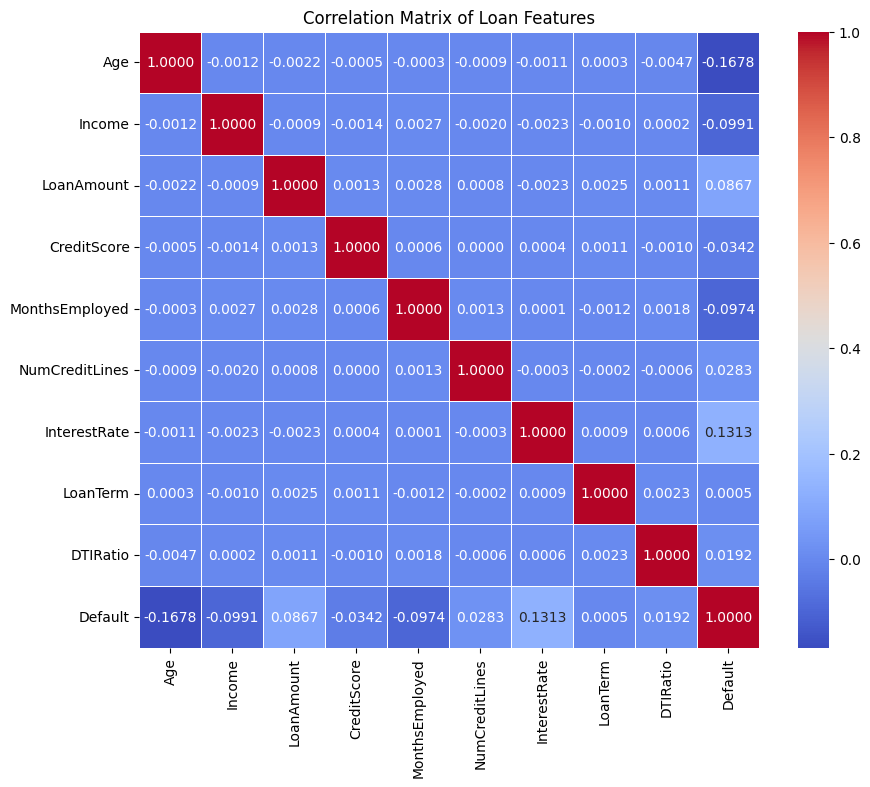

In [94]:
cols = [
    'Age', 'Income', 'LoanAmount', 'CreditScore',
    'MonthsEmployed', 'NumCreditLines',
    'InterestRate', 'LoanTerm', 'DTIRatio', 'Default'
]

# Compute correlation matrix
corr_matrix = df[cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Loan Features")
plt.show()

| Feature            | Correlation with `Default` | Interpretation                                                   |
| ------------------ | -------------------------- | ---------------------------------------------------------------- |
| **Age**            | **-0.168**                 | Younger borrowers are slightly more likely to default            |
| **InterestRate**   | **+0.131**                 | Higher interest rates are slightly associated with more defaults |
| **Income**         | -0.099                     | Lower income → slightly more likely to default                   |
| **MonthsEmployed** | -0.097                     | Less time employed → slightly more default risk                  |
| **LoanAmount**     | +0.087                     | Larger loans → slightly more default risk                        |
| **CreditScore**    | -0.034                     | Higher credit score → mildly lower default chance (expected)     |
| **DTIRatio**       | +0.019                     | Weak positive relation with default                              |
| **LoanTerm**       | \~0                        | No real correlation                                              |
| **NumCreditLines** | \~0.028                    | Almost no correlation                                            |


**Chi-Square Test of Independence (for Categorical Features)**

The Chi-Square test is a statistical method used to determine whether there is a significant association between two categorical variables.

In this context, we use it to answer the question:

*“Is this feature related to whether a customer defaults?”*

| Field            | Description                                                                                                          |
| ---------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Feature**      | The categorical column being tested against the `Default` target                                                     |
| **Chi2 Square**  | The Chi-square statistic; higher values = stronger association                                                       |
| **p-value**      | The probability that the relationship occurred by chance. A lower p-value = stronger evidence of a true relationship |
| **Significant?** | Whether the result is statistically significant (we typically use a threshold of **p < 0.05**)                       |


In [95]:
# Categorical columns to test against 'Default'
cat_cols = ['Education', 'HasMortgage', 'HasDependents', 'HasCoSigner', 'LoanPurpose', 'EmploymentType', 'MaritalStatus']

# Chi-Square results
chi2_results = []

for col in cat_cols:
    table = pd.crosstab(df[col], df['Default'])
    chi2, p, dof, ex = chi2_contingency(table)
    
    chi2_results.append({
        'Feature': col,
        'Chi2 Square': round(chi2, 2),
        'p-value': f"{p:.2e}",
        'Significant?': '✅ Yes' if p < 0.05 else '❌ No'
    })

pd.DataFrame(chi2_results)

,Feature,Chi2 Square,p-value,Significant?
0,Education,214.02,3.94e-46,✅ Yes
1,HasMortgage,133.25,7.96e-31,✅ Yes
2,HasDependents,306.85,1.06e-68,✅ Yes
3,HasCoSigner,390.31,7.10e-87,✅ Yes
4,LoanPurpose,127.93,1.08e-26,✅ Yes
5,EmploymentType,529.74,1.71e-114,✅ Yes
6,MaritalStatus,200.36,3.11e-44,✅ Yes


### 3. Prepare The Data

*Encode Categorical Data*

In [96]:
# Ordinal Ranked
education_order = ['High School', "Bachelor's", "Master's",  'PhD']
df['Education'].unique()
df['Education'] = pd.Categorical(df['Education'], categories=education_order, ordered=True)
df['Education'] = df['Education'].cat.codes  # Encoded as 0–4

# Nominal Features
categorical_columns = ["EmploymentType", "MaritalStatus", "LoanPurpose"]
df = pd.get_dummies(df, columns=categorical_columns)  # One-hot encoding


# Binary Features
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [97]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           255347 non-null  int64  
 1   Income                        255347 non-null  int64  
 2   LoanAmount                    255347 non-null  int64  
 3   CreditScore                   255347 non-null  int64  
 4   MonthsEmployed                255347 non-null  int64  
 5   NumCreditLines                255347 non-null  int64  
 6   InterestRate                  255347 non-null  float64
 7   LoanTerm                      255347 non-null  int64  
 8   DTIRatio                      255347 non-null  float64
 9   Education                     255347 non-null  int8   
 10  HasMortgage                   255347 non-null  int64  
 11  HasDependents                 255347 non-null  int64  
 12  HasCoSigner                   255347 non-nul

**Feature Engineering**

In [98]:
df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['Income'] + 1e-5)
df['MonthlyLoanPayment'] = df['LoanAmount'] / (df['LoanTerm'] + 1e-5)
df['CreditPerLine'] = df['LoanAmount'] / (df['NumCreditLines'] + 1e-5)

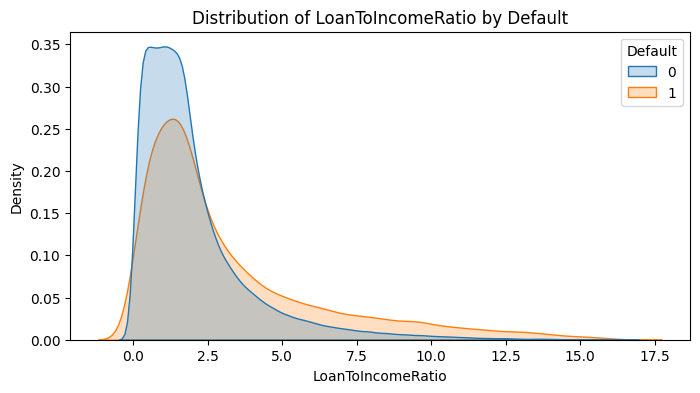

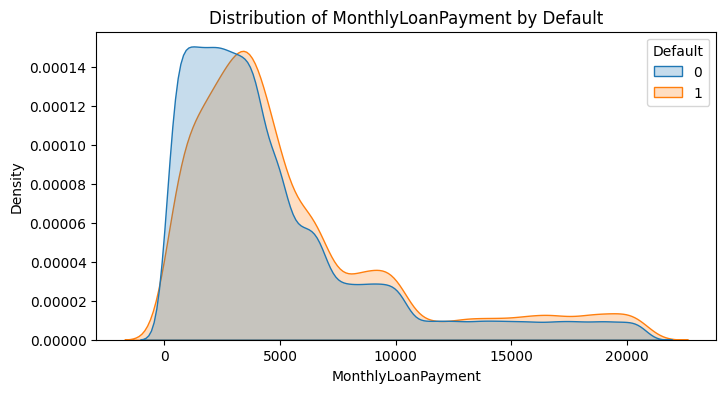

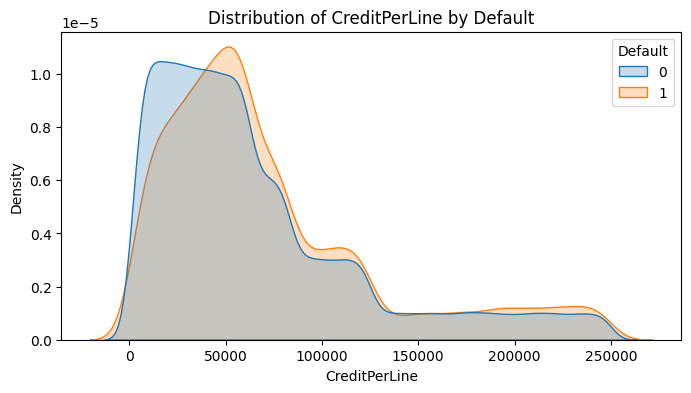

In [99]:
features = ['LoanToIncomeRatio', 'MonthlyLoanPayment', 'CreditPerLine']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=feature, hue='Default', fill=True, common_norm=False)
    plt.title(f'Distribution of {feature} by Default')
    plt.show()

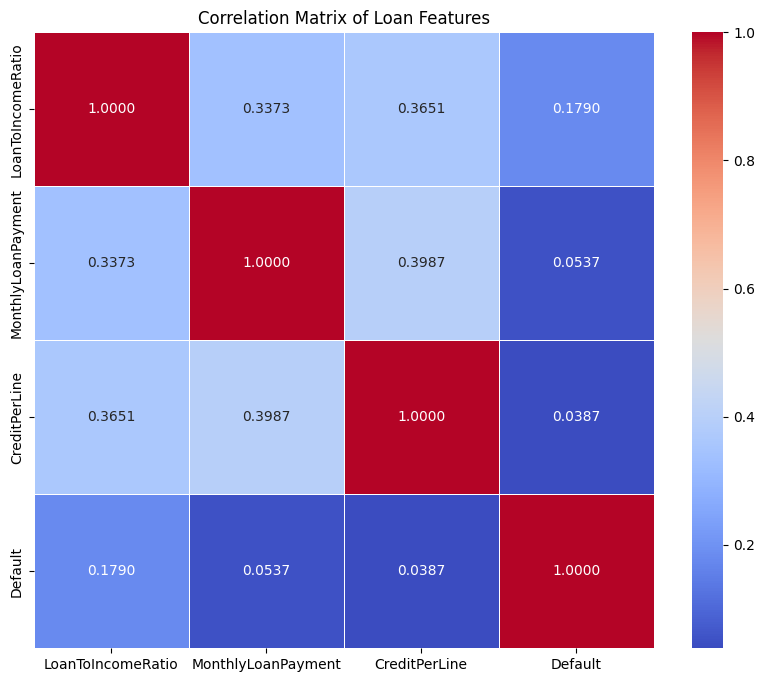

In [100]:
correlation = df[['LoanToIncomeRatio', 'MonthlyLoanPayment', 'CreditPerLine', 'Default']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".4f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Loan Features")
plt.show()

In [101]:
df['Default'].value_counts()  # Target column

Default
0    225694
1     29653
Name: count, dtype: int64

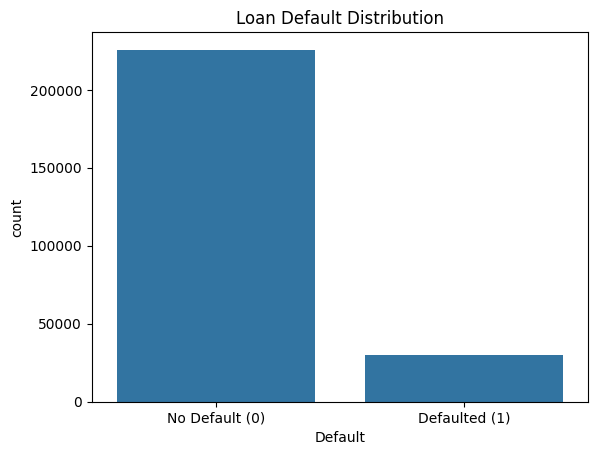

In [102]:
sns.countplot(x='Default', data=df)
plt.title('Loan Default Distribution')
plt.xticks([0, 1], ['No Default (0)', 'Defaulted (1)'])
plt.show()

*The target `Default` is imbalanced, only ~12% of the data represents people who defaulted.* 

*This might just predict `0` (no defualt) all the time and still get ~88% accuracy, but still fails at catching actual defaults*

*SOLUTION: Undersample the majority class*

*NOTE: Oversampling still introduces challenges on boosting the performance of the model. Recall score is below 0.1 which makes the model useles.*

In [103]:
# 1. Split the classes
df_default = df[df['Default'] == 1]  # minority class
df_no_default = df[df['Default'] == 0]  # majority class

# 2. Downsample the majority class 
df_no_default_downsampled = df_no_default.sample(n=int(len(df_default) * 1.2), random_state=42)

# 3. Combine both
df_balanced = pd.concat([df_no_default_downsampled, df_default])

# 4. Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [104]:
df_balanced['Default'].value_counts()

Default
0    35583
1    29653
Name: count, dtype: int64

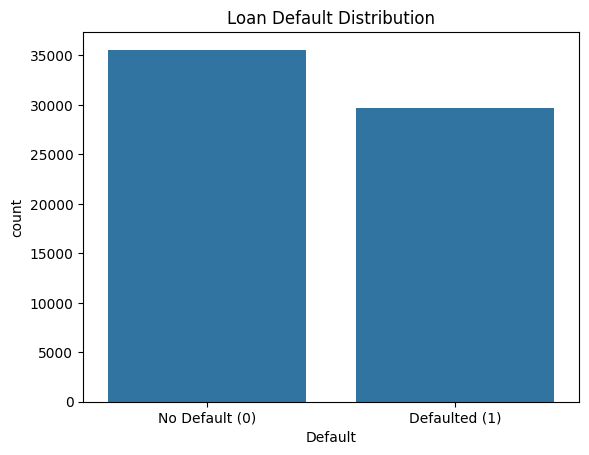

In [105]:
sns.countplot(x='Default', data=df_balanced)
plt.title('Loan Default Distribution')
plt.xticks([0, 1], ['No Default (0)', 'Defaulted (1)'])
plt.show()

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop('Default', axis=1), 
                                                    df_balanced['Default'], 
                                                    test_size = 0.4, 
                                                    random_state = 42,
                                                    stratify=df_balanced['Default'])         

### 3. Train Model

*We don't need to do `Feature Scaling` since we will be using `Tree-based` models, which are suitable for our goal*

In [111]:
def plot_conf_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_learning_curve(model, name, X, y, title="Learning Curve"):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
    plt.title(title + ' - ' + name)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

*Finding the best hyperparameter of each models using `GridSearchCV`*

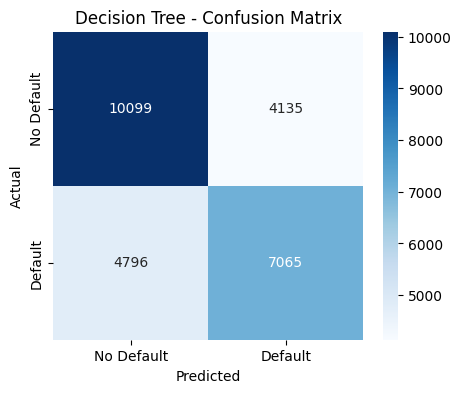

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


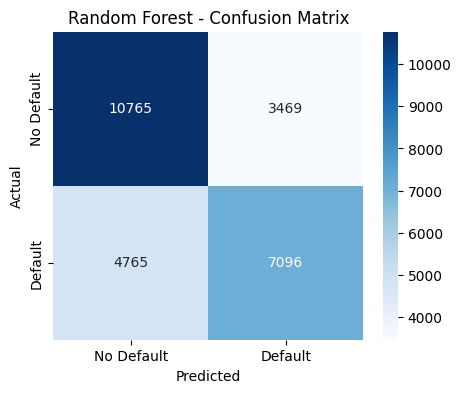

Best Random Forest Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


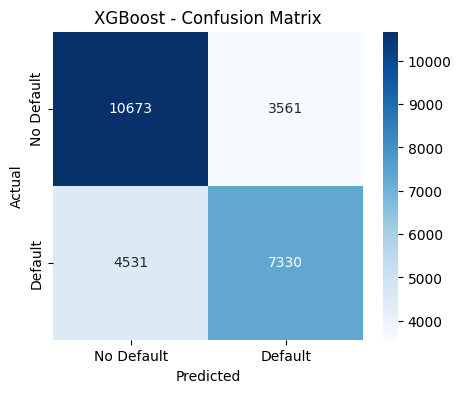

Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
0,Decision Tree,0.658,0.631,0.596,0.613,0.696,0.645
1,Random Forest,0.684,0.672,0.598,0.633,0.745,0.706
2,XGBoost,0.690,0.673,0.618,0.644,0.755,0.717


In [116]:
models = {
    "Decision Tree": GridSearchCV(
        DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini', 'entropy'],
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        },
        cv=5,
        scoring='recall',
        n_jobs=-1
    ),
    "Random Forest": GridSearchCV(
        RandomForestClassifier(),
        param_grid={
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 4],
            'max_features': ['sqrt', 'log2']
        },
        cv=3,
        scoring='recall',
        n_jobs=-1
    ),
    "XGBoost": GridSearchCV(
        XGBClassifier(),
        param_grid={
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 8],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        cv=3,
        scoring='recall',
        n_jobs=-1
    )
}
# === OUTPUT ===
# Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
# Best Random Forest Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
# Best XGBoost Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

# models = {
#     "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=1, min_samples_split=2),
#     "Random Forest": RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4, min_samples_split=2, n_estimators=200),
#     "XGBoost": XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0)
# }

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # PR AUC (Precision-Recall AUC)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall, 
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc
    })

    plot_conf_matrix(name, y_test, y_pred)
    # plot_learning_curve(model, name, X_train, y_train) # use X_train and y_train to reflect natural data
    print(f'Best {name} Params:', model.best_params_)


performance_df = pd.DataFrame(results)

# Round for better display
performance_df = performance_df.round(3)

performance_df




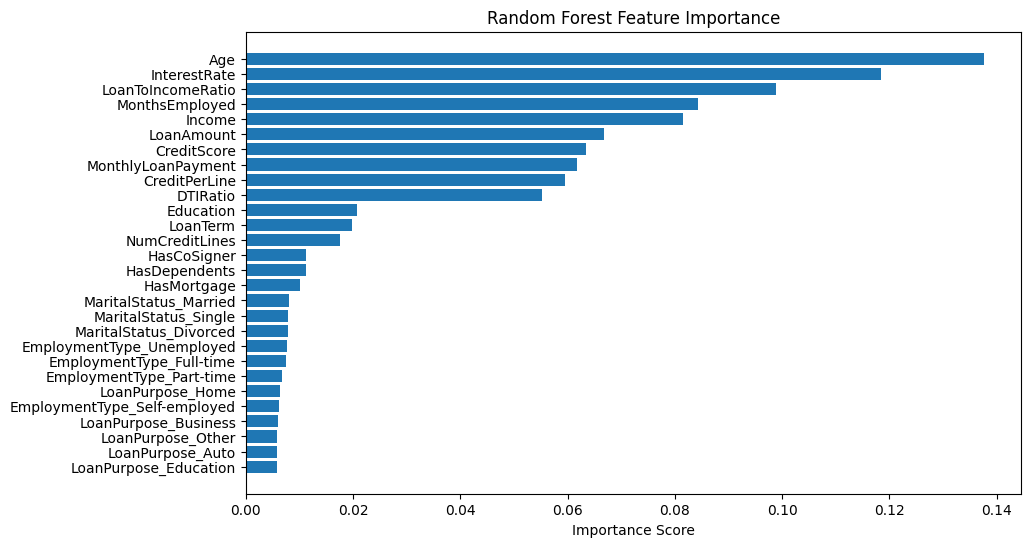

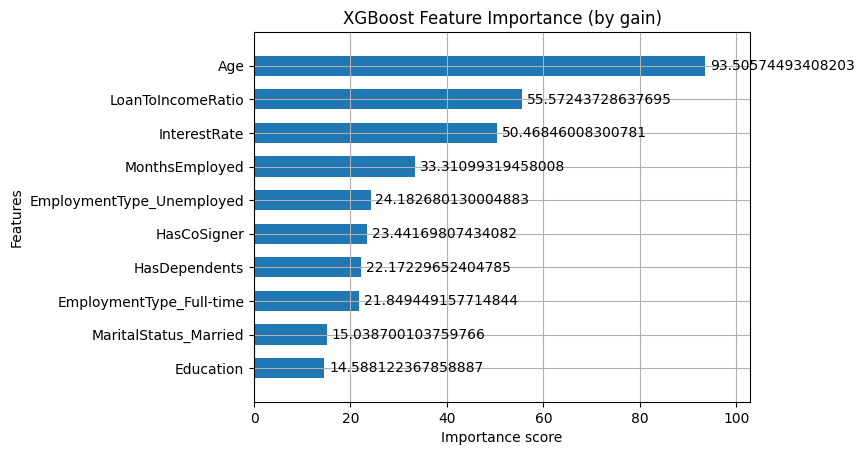

In [117]:
# Get feature importances
importances = models['Random Forest'].best_estimator_.feature_importances_
feature_names = X_train.columns  # Use your actual feature names here

# Create DataFrame and sort
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.show()

from xgboost import plot_importance

xgb_model = models['XGBoost'].best_estimator_

# Plot the top features
plot_importance(xgb_model, max_num_features=10, importance_type='gain', height=0.6)
plt.title("XGBoost Feature Importance (by gain)")
plt.show()

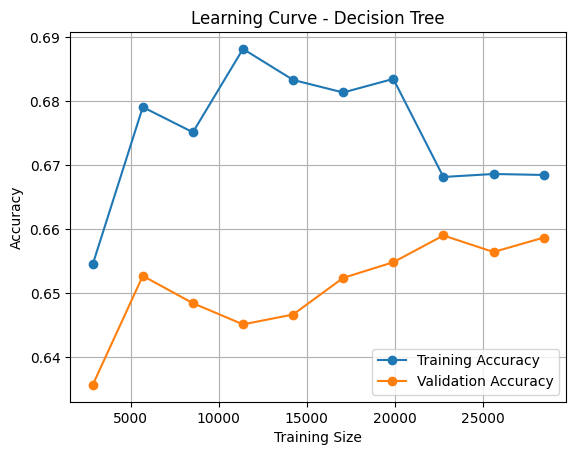

In [ ]:
# use X_train and y_train to reflect natural data
# plot_learning_curve(models['Decision Tree'], 'Decision Tree', X_train, y_train) 
# plot_learning_curve(models['Random Forest'], 'Random Forest', X_train, y_train) 
# plot_learning_curve(models['XGBoost'], 'XGBoost', X_train, y_train) 

In [119]:
import pickle

pickle.dump(models['XGBoost'], open('xgboost_model.pkl', 'wb'))

In [120]:
pickle.load(open('xgboost_model.pkl', 'rb'))

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 8],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='recall')